In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate as interp

import ase
from ase.calculators import lj
from ase import build

from ase.md.verlet import VelocityVerlet
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.io.trajectory import Trajectory

import atombond

%matplotlib inline

In [3]:
# NOTE this code uses Equilibrium Lennard-Jones Units
# Units:
#  dist   = equil sep dist of atom pair = r_min^LJ
#  energy = |Energy at equil of atom pair| = |Energy well depth| = E_d
rmin_sig = 2**(1/6)

In [4]:
def coor_cutoff(dists_a,rcut=1.5):
    assert dists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    # inputs distances and returns coordination number
    w_a = dists_a <= rcut
    coornum = np.sum(w_a)
    return coornum



In [5]:
def coor_econ(dists_a,TOL=1e-5,dosort=True,nexp=6):
    # assert len(dists_a.shape)
    assert dists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    
    if dosort:
        dists_a = np.sort(dists_a)
    
    if dists_a[0]==0:
        dists_a = dists_a[1:]
        
    dnnavg = dists_a[0]
    
    # loops until distances stop changing
    while True:
        w_a = np.exp(1 - (dists_a / dnnavg)**nexp)
        dnnavg_next = np.sum(w_a * dists_a) / np.sum(w_a)
        if np.abs(dnnavg_next/dnnavg-1) < TOL:
            break
        dnnavg = dnnavg_next
    
    coornum = np.sum(w_a)
    return coornum
# coor_econ(dists_a) 

In [6]:
def coor_sann(idists_a):
    assert idists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    N = idists_a.shape[0]
    rad1=idists_a[0]
    Nbond = 3
    # Nbond bc we want the 3rd index to be the 4th atom(the 1st atom that's not bonded)
    rnonbond = idists_a[Nbond]
    # sum over Nbond neighbors 
    rshell = np.sum(idists_a[:Nbond]/(Nbond-2))
    while rshell > rnonbond:
        Nbond += 1
        rshell = np.sum(idists_a[:Nbond]/(Nbond-2))
        rnonbond = idists_a[Nbond]
        
        
    w_a = (1-idists_a[:Nbond]/rshell)/(1-rad1/rshell)      
    coornum = np.sum(w_a)
    return coornum

# coor_sann(idists_a)

In [35]:
# for dist in idists_a:
# nn = coor_cutoff(dists_a,rcut=1.5)
g_a = (1/np.sqrt(2*np.pi))*np.exp((-1/2)*idists_a[:11]**2)
print(np.sum(g_a))


2.11971028657


In [59]:
def calc_kernel_density(dists_a):
    rhobar = 1
    #FIX
    bandwidth = .15
    Nsamp = 1001
    pdf_approx_a = np.zeros(Nsamp)
    sampdist_a = np.linspace(0.001, Lat/2, Nsamp)
    for ind in np.arange(dists_a.size):
        #calculates the observed number of atoms per angstrom
        #if integrated, coordination number is given
        # dn_dr_a = (1/np.sqrt(2*np.pi)/bandwidth)*np.exp((-1/2)*(dists_a[ind]-sampdist_a)**2/(bandwidth**2))
        dn_dr_a = (1/np.sqrt(2*np.pi)/bandwidth)*np.exp((-1/2)*(dists_a[ind]-sampdist_a)**2/(bandwidth**2))
        g_a = dn_dr_a/(4*np.pi*sampdist_a**2*rhobar)
        #print(g_a)
    
        pdf_approx_a += g_a/dists_a.size/.0018
        
    return pdf_approx_a, sampdist_a


pdf_approx_grid_a = []
#print(dists_a.shape)

for ind in np.arange(dists_a.shape[0]):
    ipdf_a, sampdist_a = calc_kernel_density(dists_a[ind])
    pdf_approx_grid_a.append(ipdf_a)
    
pdf_approx_grid_a = np.array(pdf_approx_grid_a)


235156.38887


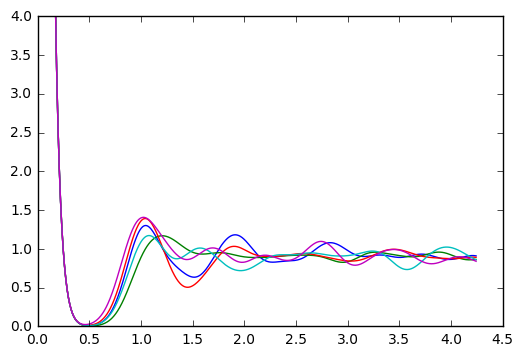

In [62]:
pdf_approx_grid_a.shape
plt.plot(sampdist_a, pdf_approx_grid_a.T[:,::100], '-');
plt.ylim(0,4)

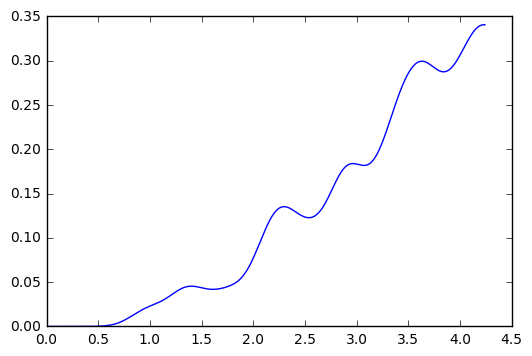

In [50]:
bandwidth = 0.15
Nsamp = 1001
pdf_approx_a = np.zeros(Nsamp)
sampdist_a = np.linspace(0, Lat/2, Nsamp)
for ind in np.arange(idists_a.size):
    g_a = (1/np.sqrt(2*np.pi)/bandwidth)*np.exp((-1/2)*(idists_a[ind]-sampdist_a)**2/(bandwidth**2))
    pdf_approx_a += g_a/idists_a.size

plt.plot(sampdist_a, pdf_approx_a, 'b-')


In [10]:
# Nx = 9 
# liq_at = get_lj_fcc_struc(nabc_super=[Nx,Nx,Nx],dNN=1.1)

In [11]:
Nx = 5
liq_at = atombond.get_lj_fcc_struc(super_a=[Nx,Nx,Nx],dNN=1.2,E_lj=1/40)

In [12]:
Nat = liq_at.get_number_of_atoms()
Vat = liq_at.get_volume()
Lat = (Vat)**(1/3)
rhoat = Nat/Vat
print(rhoat)

0.818410626373


In [13]:
print(Nat)
print(Vat/Nat)
print(rhoat)


500
1.22188051789
0.818410626373


In [14]:
# np.sort(liq_at.get_all_distances(mic=True).ravel())[Nat:]
# liq_at.get_cell()

In [15]:
"""
T=600
# gbins=30
# grange=[.5,2.7]

traj_filenm = 'test.traj'
Nstep = 300
traj_freq = 10


atombond.run_mdsim(liq_at,T,Nstep,Tdampfac=30,dt=1e-2,rand_vel=True,traj_filenm=traj_filenm,traj_freq=traj_freq)
"""

"\nT=600\n# gbins=30\n# grange=[.5,2.7]\n\ntraj_filenm = 'test.traj'\nNstep = 300\ntraj_freq = 10\n\n\natombond.run_mdsim(liq_at,T,Nstep,Tdampfac=30,dt=1e-2,rand_vel=True,traj_filenm=traj_filenm,traj_freq=traj_freq)\n"

In [16]:
traj_filenm = 'lj_rho0.82_T600_N500.traj'
traj = Trajectory(traj_filenm)

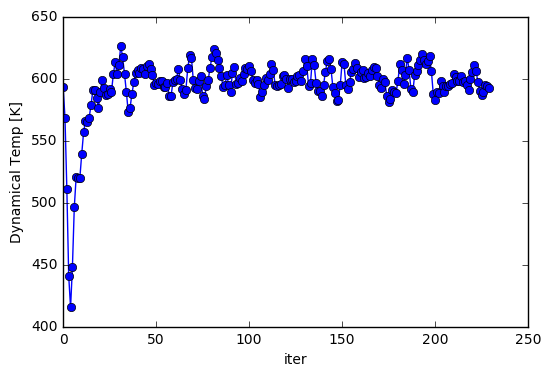

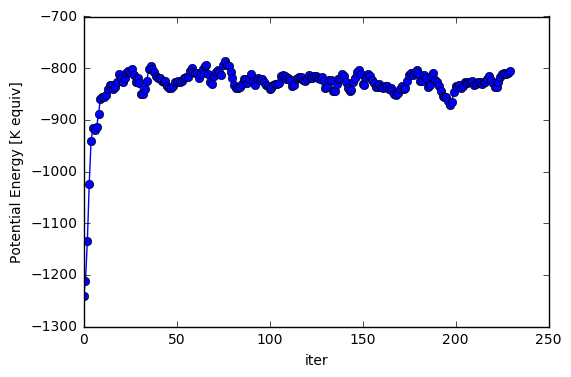

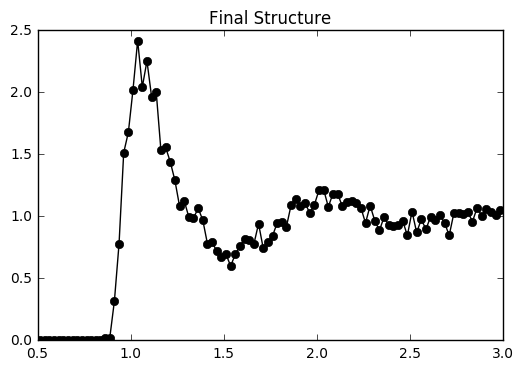

In [17]:
atombond.plot_energy_convergence(traj_filenm,istart=0)

In [18]:
atoms=traj[-1]
Vtot = atoms.get_volume()
print(Vtot)
dist_a=atoms.get_all_distances(mic=True)
dists_a = np.sort(dist_a)

610.940258945


In [19]:
print(dists_a.shape)
coor_cutoff(dists_a,rcut=1.5)

(500, 500)


AssertionError: dists_a must be a 1 dimensional array

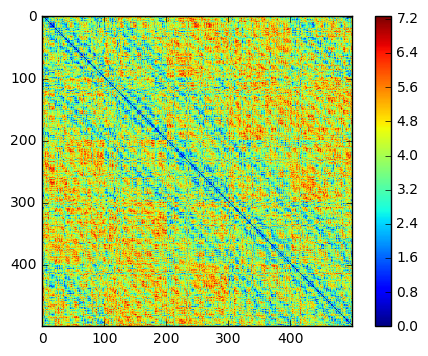

In [20]:
plt.imshow(dist_a)
plt.colorbar()

In [21]:
iecon = coor_econ(idist_a)
print(iecon)

NameError: name 'idist_a' is not defined

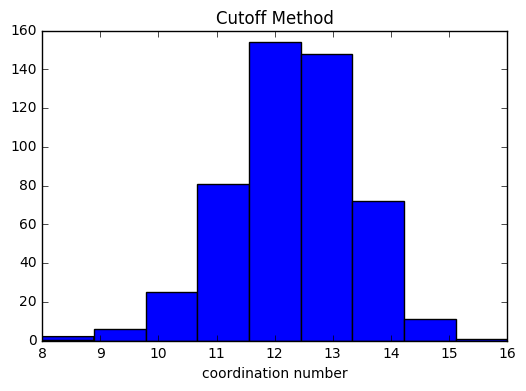

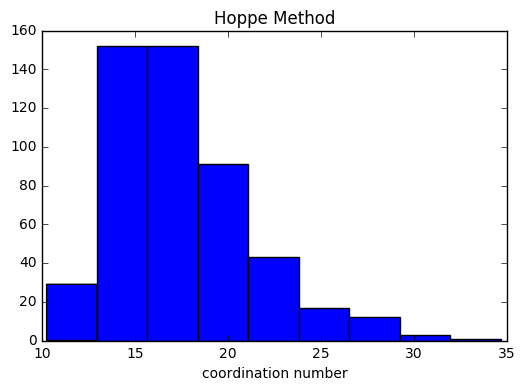

In [22]:
N = dist_a.shape[0]
cn_cutoff_a = np.zeros(N)
cn_econ_a = np.zeros(N)
for ind in np.arange(N):
    idist_a = dist_a[ind]
    icutoff = coor_cutoff(idist_a,rcut=1.5)
    iecon = coor_econ(idist_a,nexp=3)
    
    cn_cutoff_a[ind] = icutoff
    cn_econ_a[ind] = iecon
    

plt.hist(cn_cutoff_a,9)
plt.xlabel('coordination number')
plt.title('Cutoff Method')
plt.figure()

plt.hist(cn_econ_a,9)
plt.xlabel('coordination number')
plt.title('Hoppe Method')

In [23]:
N = dist_a.shape[0]
cn_cutoff_a = np.zeros(N)
cn_econ_a = np.zeros(N)
cn_sann_a = np.zeros(N)
for ind in np.arange(N):
    idists_a = distalls_a[ind]
    icutoff = coor_cutoff(idists_a,rcut=1.5)
    iecon = coor_econ(idists_a)
    isann = coor_sann(idists_a)
    
    cn_cutoff_a[ind] = icutoff
    cn_econ_a[ind] = iecon
    cn_sann_a[ind]= isann
    

plt.hist(cn_cutoff_a,9)
plt.xlabel('coordination number')
plt.title('Cutoff Method')
plt.xlim(0,15)
plt.figure()

plt.hist(cn_econ_a,9)
plt.xlabel('coordination number')
plt.title('Hoppe Method')
plt.xlim(0,15)

plt.figure()
plt.hist(cn_sann_a,10)
plt.xlabel('coordination number')
plt.title('Sann Method')
plt.xlim(0,15)

NameError: name 'distalls_a' is not defined

In [ ]:
distalls_a=np.sort(dist_a,axis=1)[:,1:]
distalls_a[-1]
# plt.imshow(distalls_a)
plt.hist(distalls_a[:,0],10)
plt.figure()

nn_num=9

plt.plot((distalls_a[:,0]),(distalls_a[:,nn_num]), 'x')
print(distalls_a.shape)
iatom = 20
print(coor_cutoff(distalls_a[iatom]))
print(coor_econ(distalls_a[iatom]))
print(coor_sann(distalls_a[iatom]))

(498,)


(0, 0.07)

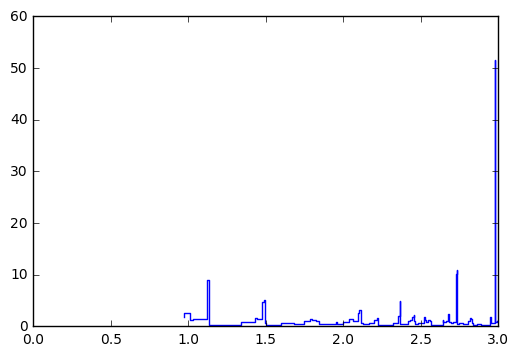

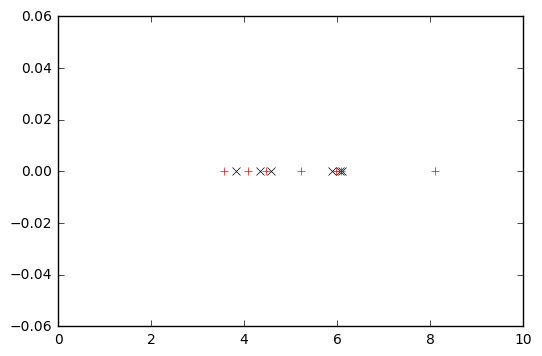

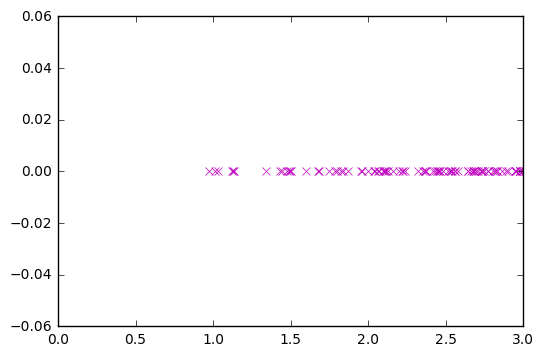

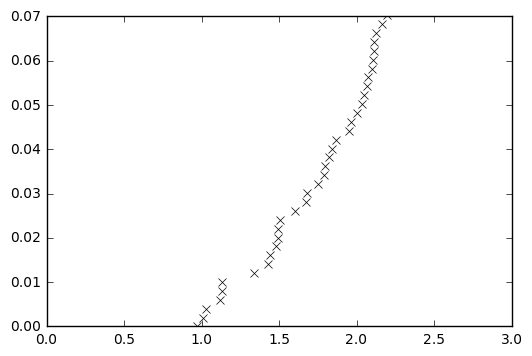

In [24]:
idist_a = dist_a[30]
idist_a.shape
idists_a= np.sort(idist_a)[1:]
frac_a = np.linspace(0,1,idists_a.size)
#print(idists_a)
iVol_a = 4/3*np.pi*idists_a**3

# calculates midpoint for volume
iVolmid_a=0.5*np.diff(iVol_a)+iVol_a[:-1]
iVolbound0 = iVol_a[0] - 0.5*(iVol_a[1]-iVol_a[0])
# iVolbound0 = iVol_a[0] - (iVolmid_a[0]-iVol_a[0])
iVolbound_a = np.hstack((iVolbound0,iVolmid_a))

idVol_a = np.diff(iVolbound_a)
print(idVol_a.shape)
# print(iVolbound_a)
rho_a = 1/idVol_a

plt.step(idists_a[0:99], rho_a[0:99], where='pre')
plt.xlim(0,3)
plt.figure()

plt.plot(iVol_a, 0*iVol_a, 'kx')
plt.plot(iVolbound_a,0*iVolbound_a, 'r+')
plt.xlim(0, 10)
plt.figure()

plt.plot(idists_a, 0*idists_a, 'mx')
plt.xlim(0,3)

plt.figure()

plt.plot(idists_a,frac_a,'kx')
plt.xlim(0,3)
plt.ylim(0,0.07)



(0, 3)

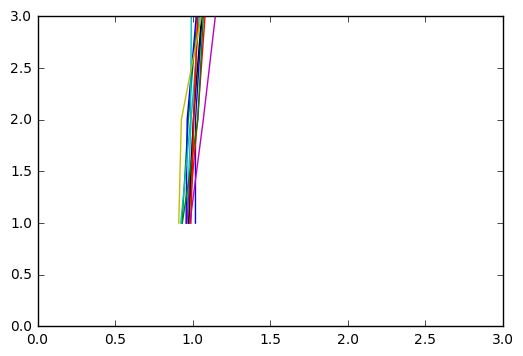

In [25]:
# np.arange(dist_a.shape[0])
for iat in np.arange(dist_a.shape[0])[::40]:
    idist_a = dist_a[iat]
    idist_a.shape
    idists_a= np.sort(idist_a)[1:]
    num_a = np.arange(1,idists_a.size+1)
    #print(idists_a)
    plt.plot(idists_a,num_a,'-')

plt.xlim(0,3)
plt.ylim(0,3)

In [26]:
for atoms in traj:
    # print(atoms)
    d=atoms.get_distances()
    print(d)
    

TypeError: get_distances() missing 2 required positional arguments: 'a' and 'indices'

In [27]:
len(traj)

230

In [28]:
atoms.get_number_of_atoms()

500

In [29]:
print(atombond.calc_pdf( liq_at, dist_range=[.5,3], nbins=50 ) ) 
# print(calc_coor_num(rhoat,r_a,g_dat_a,debug=False,Nsamp=1001))

(array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   9.31367338,   7.01099446,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   4.1668485 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  10.8610636 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   3.27478958,   0.83498755,   0.        ,
         0.        ,   0.        ,   0.        ,   6.53535759,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.82199005,   0.        ]), array([ 0.525,  0.575,  0.625,  0.675,  0.725,  0.775,  0.825,  0.875,
        0.925,  0.975,  1.025,  1.075,  1.125,  1.175,  1.225,  1.275,
        1.325,  1.375,  1.425,  1.475,  1.525,  1.575,  1.625,  

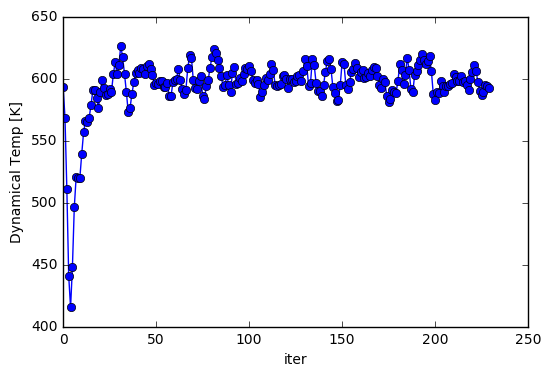

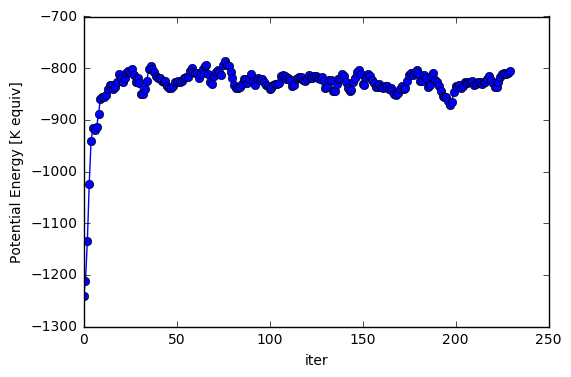

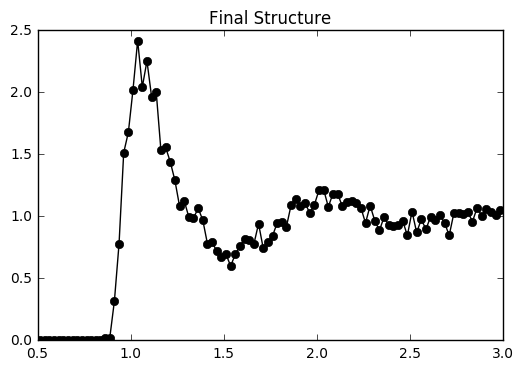

In [30]:
atombond.plot_energy_convergence(traj_filenm,istart=0)

In [31]:
Nstep = 1000
atombond.run_mdsim(liq_at,T,Nstep,Tdampfac=30,traj_filenm=traj_filenm,traj_freq=traj_freq,traj_append=True)

NameError: name 'T' is not defined

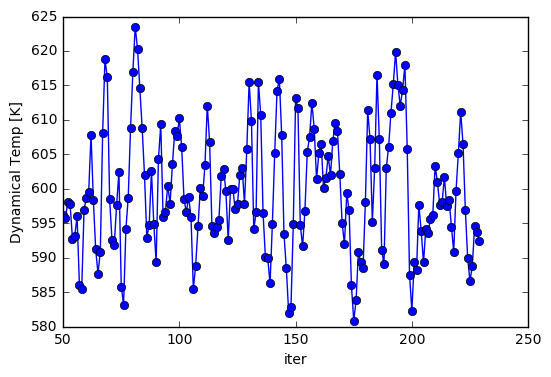

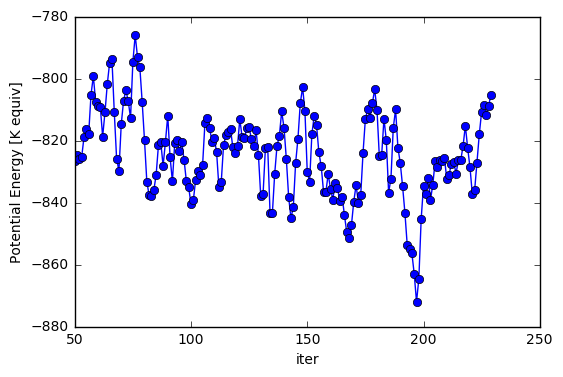

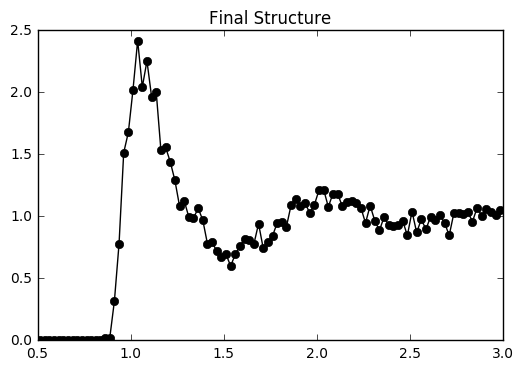

In [32]:
atombond.plot_energy_convergence(traj_filenm,istart=50)

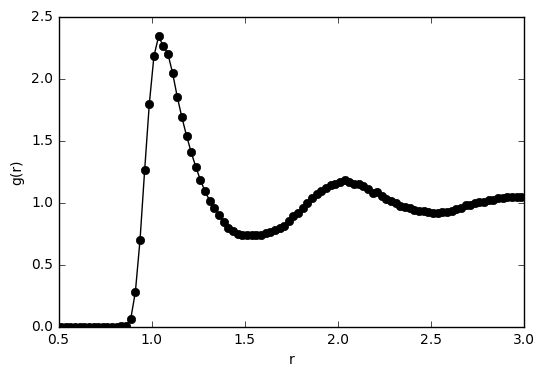

In [33]:
r_a, g_avg_a = atombond.calc_avg_pdf(traj_filenm, istart=50,dist_range = [0.5,3.0],nbins=100)
plt.plot(r_a,g_avg_a,'ko-')
plt.xlabel('r')
plt.ylabel('g(r)')

In [34]:
atombond.calc_coor_num(rhoat,r_a,g_avg_a,debug=False,Nsamp=1001)


12.541068449980701